# Heart Failure Prediction using Decision Trees, Random Forests and Gradient Boosting

The dataset used in this notebook is the [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) from Kaggle.

It contains 12 features that can be used to predict mortality by heart failure.

**Context**

+ Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attack and stroke.
+ People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes or hyperlipidaemia) need early detection and management wherein a machine learning model can be of great help. 
+ This dataset contains 11 features that can be used to predict possible heart disease.

**Attribute Information**

+ Age: Age of the patient [years]
+ Sex: Sex of the patient [M: Male, F: Female]
+ ChestPainType: Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
+ RestingBP: Resting blood pressure [mm Hg]
+ Cholesterol: Serum cholesterol [mm/dl]
+ FastBS: Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
+ RestingECG: Resting electrocardiographic results [Normal: Normal, ST: having ST-T wave abnormality, LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
+ MaxHR: Maximum heart rate achieved [Numeric value between 60 and 202]
+ ExerciseAngina: Exercise-induced angina [Y: Yes, N: No]
+ Oldpeak: ST depression induced by exercise relative to rest [Numeric value measured in depression]
+ ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
+ HeartDisease: Heart disease [0: No, 1: Yes]

In [20]:
# libraries
import numpy as np 
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from xgboost import  XGBClassifier
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('seaborn-v0_8')
RANDOM_STATE = 55 ## We will pass this state to every sklearn call to ensure reproducibility

In [21]:
%config InlineBackend.figure_format = 'svg'

The following variables in the dataset are categorical, so they can be one-hot encoded:

+ Sex
+ ChestPainType
+ RestingECG
+ ExerciseAngina
+ ST_Slope

In [22]:
# loading the entire dataset as a pandas dataframe
df = pd.read_csv('data/Files/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## One Hot Encoding using Pandas

First, we will remove the binary variables, as one-hot encoding is not required for them.

We will achieve this by just counting the number of different categorical values per variable and only consider those with more than 2 labels. 

In [23]:
cat_variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

As a reminder, one-hot encoding is a process which aims at converting a categorical value of $n$ outputs into a binary vector of $n$ dimensions, where only one dimension is 1 and the rest are 0. 

Pandas has a built-in function called `get_dummies` which can be used to perform one-hot encoding.

The arguments we will use are:

+ `data`: the target dataframe
+ `prefix`: the prefixes list for the new columns
+ `columns`: the columns to be encoded, which should be the same length as the prefixes list

In [24]:
# This will replace the target columns with the one-hot encoded ones while keeping all the others unvaried
df = pd.get_dummies(data=df, prefix = cat_variables, columns = cat_variables)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


Our target variable is `HeartDisease`, so we will drop it from the dataframe. 

In [25]:
features = [x for x in df.columns if x not in 'HeartDisease'] # removing target variable

In [26]:
len(features)

20

## Splitting the Dataset 

We will split the dataset into training and cross-validation sets. 

We can immediately achieve this by using the `train_test_split` function from `sklearn.model_selection`.

In [27]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state=RANDOM_STATE)
# We will keep the shuffle = True since our dataset has not any time dependency.

In [28]:
print(f'train samples: {len(X_train)} | validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734 | validation samples: 184
target proportion: 0.5518


## Building the models 

### Decision Tree 

We will use the `DecisionTreeClassifier` class from `sklearn.tree` to build the decision tree model. 

Among the many hyperparameters that can be tuned, we will focus on the following, which we won't be tuning:

+ **min_samples_split**: the minimum number of samples required to split an internal node
    + Choosing a higher value will prevent the model from overfitting by reducing the number of splits
+ **max_depth**: the maximum depth of the tree
    + Choosing a lower value can reduce the number of splits and prevent overfitting 

In [29]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

In [30]:
accuracy_list_train = [] # init
accuracy_list_val = []

for min_samples_split in min_samples_split_list: 
    # fitting the model while defining it
    model = DecisionTreeClassifier(min_samples_split = min_samples_split, random_state = RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train) ## Predicted values for the train dataset
    predictions_val = model.predict(X_val)     ## Predicted values for the cross-validation dataset

    accuracy_train = accuracy_score(predictions_train, y_train) ## sklearn function that evaluates prediction accuracy
    accuracy_val = accuracy_score(predictions_val, y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)


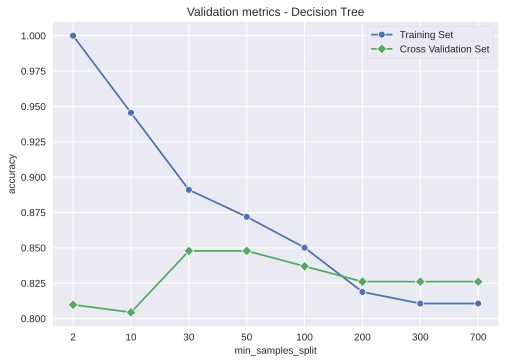

In [31]:
# plotting the accuracy in train and cross-validations sets

sns.lineplot(data=accuracy_list_train, marker='o', label='Training Set')
sns.lineplot(data=accuracy_list_val, marker='D', label='Cross Validation Set')
plt.title('Validation metrics - Decision Tree')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.legend(loc='upper right', frameon=True, framealpha=1)
plt.show()

Notice how reducing the number of splits (by increasing the value of  `min_samples_split`) can reduce overfitting.

Let's now see the same experiment with `max_depth`.

In [32]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list: 
    # fit the model while defining it
    model = DecisionTreeClassifier(max_depth = max_depth, random_state = RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

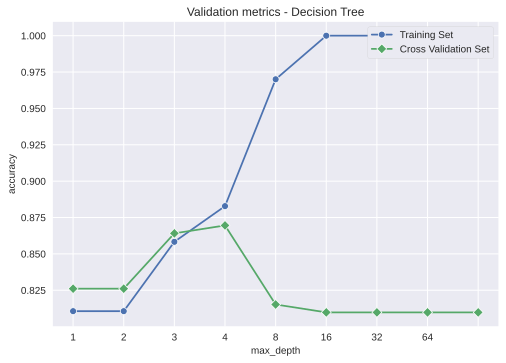

In [33]:
# plotting the accuracy in train and cross-validations sets

sns.lineplot(data=accuracy_list_train, marker='o', label='Training Set')
sns.lineplot(data=accuracy_list_val, marker='D', label='Cross Validation Set')
plt.title('Validation metrics - Decision Tree')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)),labels=max_depth_list)
plt.legend(loc='upper right', frameon=True, framealpha=1)
plt.show()

The results are different compared to the previous experiment. While there was a clear benefit in reducing the number of splits by increasing the value of `min_samples_split`, increasing the value of `max_depth` has different outcomes instead. 

+ Reducing max_depth from 8 to 4 has a negative impact on the training accuracy, but a positive impact on the cross-validation accuracy, which closes the gap between the two accuracies. 
+ The validation accuracy reaches a maximum at `max_depth=4`, which is the best value for this hyperparameter when considered in isolation. 
+ Both accuracies go down when `max_depth` is below 3, which means that the model is underfitting.
+ Increasing `max_depth` beyond 5 hits a point of diminishing returns, as the training accuracy keeps increasing, but the cross-validation accuracy actually goes down, meaning that the model is overfitting.

We can pick the best values for both hyperparameters: 

+ `min_samples_split=50`
+ `max_depth=4`

In [34]:
decision_tree_model = DecisionTreeClassifier(min_samples_split=50, max_depth=3, random_state=RANDOM_STATE).fit(X_train, y_train)

In [35]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


This particular model does not overfit, as the gap between the training and cross-validation accuracies is small, however, it is not the best model we can build.

### Random Forest

Scikit-learn has a `RandomForestClassifier` class which can be used to build a random forest model.

+ All the hyperparameters that can be tuned for a decision tree can also be tuned for a random forest, which is just an ensemble of decision trees.
+ One additional hyperparameter that can be tuned is `n_estimators`, which is the number of Decision Trees in the Random Forest.

Remember that for a random forest, we **randomly** choose a subset of features AND a subset of samples for each tree.

+ We will randomly select $\sqrt{n}$ features, where $n$ is the total number of features for each tree.

Another parameter that can be tuned is `n_jobs`, which is the number of jobs to run in parallel (i.e. fitting more than one tree at a time).

+ Since the fitting of each tree is independent of the others, we can fit multiple trees at the same time, which will speed up the training process.
+ Setting `n_jobs` higher will increase the number of CPU cores used. 
+ Changing this parameters only impact the computation speed, not the result nor the accuracy of the model.

We will also use the `n_estimators` parameter to see how the number of trees in the forest affects the accuracy of the model.

In [36]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None] 
n_estimators_list = [10, 50, 100, 500] ## default is 100

In [37]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    # fit the model while defining it
    model = RandomForestClassifier(min_samples_split = min_samples_split, random_state = RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

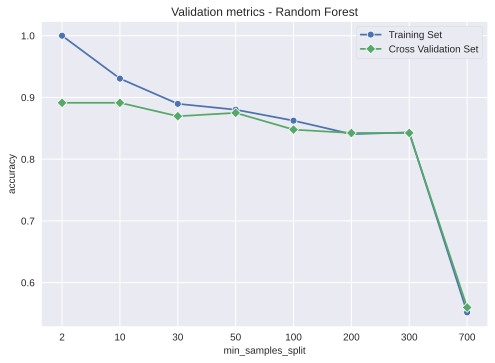

In [38]:
# plotting the accuracy in train and cross-validations sets

sns.lineplot(data=accuracy_list_train, marker='o', label='Training Set')
sns.lineplot(data=accuracy_list_val, marker='D', label='Cross Validation Set')
plt.title('Validation metrics - Random Forest')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list)),labels=min_samples_split_list)
plt.legend(loc='upper right', frameon=True, framealpha=1)
plt.show()

Notice that the accuracy of both the training and cross-validation sets decreases as the number of splits decreases, farly slowly at first, but with a rapid decline after 300 minimum samples per split. 

The best compromise would be to pick a value of 10 minimum samples per split, since both accuracies are still high, and the gap between them is not too big, which prevents overfitting.

In [40]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    # fit the model while defining it
    model = RandomForestClassifier(max_depth = max_depth, random_state = RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

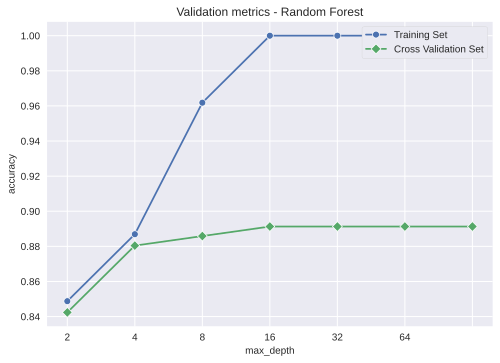

In [41]:
# plotting the accuracy in train and cross-validations sets

sns.lineplot(data=accuracy_list_train, marker='o', label='Training Set')
sns.lineplot(data=accuracy_list_val, marker='D', label='Cross Validation Set')
plt.title('Validation metrics - Random Forest')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)),labels=max_depth_list)
plt.legend(loc='upper right', frameon=True, framealpha=1)
plt.show()

In [43]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

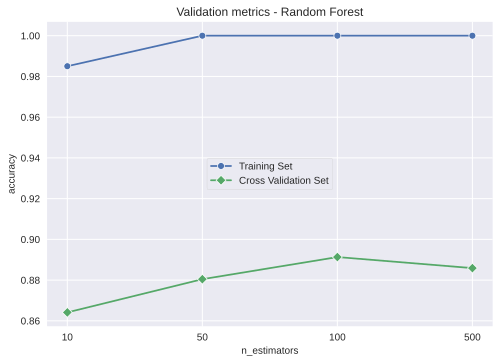

In [45]:
# plotting the accuracy in train and cross-validations sets

sns.lineplot(data=accuracy_list_train, marker='o', label='Training Set')
sns.lineplot(data=accuracy_list_val, marker='D', label='Cross Validation Set')
plt.title('Validation metrics - Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list)),labels=n_estimators_list)
plt.legend(loc='center', frameon=True, framealpha=1)
plt.show()

Final parameters:

+ `min_samples_split=10`
+ `max_depth=16`
+ `n_estimators=100`

In [46]:
random_forest_model = RandomForestClassifier(min_samples_split=10, max_depth=16, n_estimators=100).fit(X_train, y_train)

In [47]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9292
Metrics test:
	Accuracy score: 0.8913


Note that we're searching for a best hyperparameter at a time, while keeping the others fixed. In order to find the best combination of hyperparameters, we would need to perform a grid search, which is a process that tries all possible combinations of hyperparameters and picks the best one. 

This can be further explored with the `GridSearchCV` class from `sklearn.model_selection`.

### Gradient Boosting with XGBoost

XGBoost is a library that implements gradient boosting, a method that rather than building uncorrelated trees like a random forest, builds trees that are correlated with each other. 

It trains trees in a serial manner, where each tree tries to correct the mistakes of the previous one.

XGBoost is one of the most popular machine learning libraries, and it is used in many Kaggle competitions. 

One interesting aspect of XGBoost is that, while fitting a tree, it can take in an evaluation dataset of the form $(X_{val}, y_{val})$.

+ On each iteration, it measures the cost function on the validation set
+ Once the cost (or metric) stops decreasing for a certain number of iterations (called `early_stopping_rounds`), it stops training the model
+ More iterations lead to more estimators, which can lead to overfitting 
+ By stopping the training process once the metric stops improving, we can prevent overfitting

Let's start by defining a subset of the training set, which will be used as the validation set (we should not be using the test set for this purpose).

In [48]:
n = int(len(X_train) * 0.8) ## 80% of the dataset
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

Note some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.
  - The model keeps track of the round with the best performance (lowest evaluation metric).  For example, let's say round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  If the model goes 10 rounds where none have a better metric than the best one, then the model stops training.
  - The model is returned at its last state when training terminated, not its state during the best round.  For example, if the model stops at round 26, but the best round was 16, the model's training state at round 26 is returned, not round 16.
  - Note that this is different from returning the model's "best" state (from when the evaluation metric was the lowest).

In [50]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.64479
[1]	validation_0-logloss:0.60569
[2]	validation_0-logloss:0.57481
[3]	validation_0-logloss:0.54947
[4]	validation_0-logloss:0.52973
[5]	validation_0-logloss:0.51331
[6]	validation_0-logloss:0.49823
[7]	validation_0-logloss:0.48855
[8]	validation_0-logloss:0.47888
[9]	validation_0-logloss:0.47068
[10]	validation_0-logloss:0.46507
[11]	validation_0-logloss:0.45832
[12]	validation_0-logloss:0.45557
[13]	validation_0-logloss:0.45030
[14]	validation_0-logloss:0.44653
[15]	validation_0-logloss:0.44213
[16]	validation_0-logloss:0.43948
[17]	validation_0-logloss:0.44088
[18]	validation_0-logloss:0.44358
[19]	validation_0-logloss:0.44493
[20]	validation_0-logloss:0.44294
[21]	validation_0-logloss:0.44486
[22]	validation_0-logloss:0.44586
[23]	validation_0-logloss:0.44680
[24]	validation_0-logloss:0.44925
[25]	validation_0-logloss:0.45383


/home/giorgio/anaconda3/envs/ML/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=55, ...)

Notice how we allowed up to 500 rounds of training, but the model stopped at round 26, to prevent overfitting. 

In [51]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9251
Metrics test:
	Accuracy score: 0.8641


The performance of the Random Forest model from Scikit-learn is not as good as the one from XGBoost, but it is still a good model.